# First we define all the import libraries before starting the questions

In [740]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Q1

## Step 1 : Extracting the data

In [741]:
# Extracting the entire dataset (code borrowed from kaggle link that sir provided)

with h5py.File("full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]     
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:]  

In [742]:
# Each data sample is 16x16x16 in 1 channel
# -1 indicates the total number of samples
X_train = X_train.reshape(-1, 16, 16, 16, 1)
X_test = X_test.reshape(-1, 16, 16, 16, 1)

## Step 2 : Implementing 3D Convolution function

In [743]:
# Defining the activation functions
def apply_activation(X,activation):
    if(activation=='relu'):
        return np.maximum(0,X)
    elif(activation=='tanh'):
        return np.tanh(X)
    elif(activation=='sigmoid'):
        return 1/(1+np.exp(-X))
    elif(activation=='leaky_relu'):
        return np.where(X > 0, X, 0.01 * X)

In [744]:
# Forward pass convolution
def forward_pass_conv(X, kernel_size, no_of_filters, stride=1,padding=0, activation='relu'):
    in_channels=X.shape[3]

    d,h,w=kernel_size

    # Generating the kernel
    k=np.random.randn(d,h,w,in_channels,no_of_filters)

    D,H, W, _ = X.shape


    # Ensure that padding is applied
    X_with_padding = np.zeros((D+2*padding,H+2*padding,W+2*padding,in_channels))
    X_with_padding[padding:D+padding,padding:H+padding,padding:W+padding,:]=X

    D,H, W, _ = X_with_padding.shape

    # Ensure we compute the correct size of the ouput
    output_D = (D-d)//stride + 1
    output_H = (H-h)//stride + 1
    output_W = (W-w)//stride + 1

    # Initialize the output matrix
    output = np.zeros((output_D,output_H, output_W, no_of_filters))

    for f in range(no_of_filters):
        for i in range(output_D):
            for j in range(output_H):
                for l in range(output_W):
                    # Apply the kernel
                    output[i,j,l,f] = np.sum(X_with_padding[i*stride:i*stride+d, j*stride:j*stride+h, l*stride:l*stride+w, :] * k[:, :, :, :, f])

    # Apply activation function before returning
    return apply_activation(output,activation)

In [745]:
# Function to display the input 3D point cloud
def display_cloud(data,title):
    fig = plt.figure(figsize=(8,8))

    # We use the below line for 3d plots
    ax=fig.add_subplot(111,projection='3d')

    # Find the coordinates where the points are significant, i.e. > 0.25
    x,y,z=np.where(data[:,:,:,0]>0.25)
    
    # Plot the scatter plot
    ax.scatter(x, y, z, c=data[x,y,z,0],cmap='viridis')

    # Set the title
    ax.set_title(title)

#  Function to display output activation map
def display_act_map(data,title):
    num_kernels = data.shape[3]

    fig, axes = plt.subplots(1, num_kernels, figsize=(8*num_kernels, 8), subplot_kw={'projection': '3d'})

    if num_kernels == 1:
        axes = [axes]

    for c,ax in enumerate(axes):
        # Find the coordinates where the points are significant, i.e. > 0.25
        x,y,z=np.where(data[:,:,:,c]>0.25)
        
        # Plot the scatter plot
        ax.scatter(x, y, z, c=data[x,y,z,c],cmap='viridis')

        # Set the title
        ax.set_title(f'{title} : kernel no : {c}')
    plt.show()

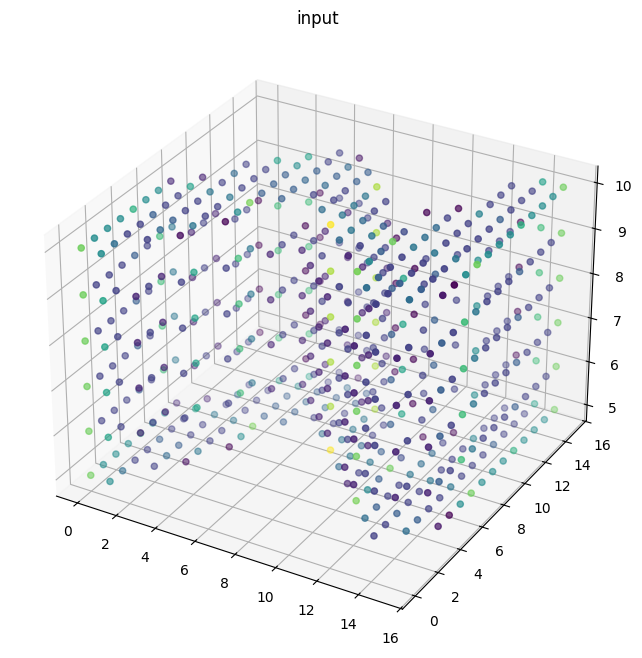

In [746]:
display_cloud(X_train[0],"input")

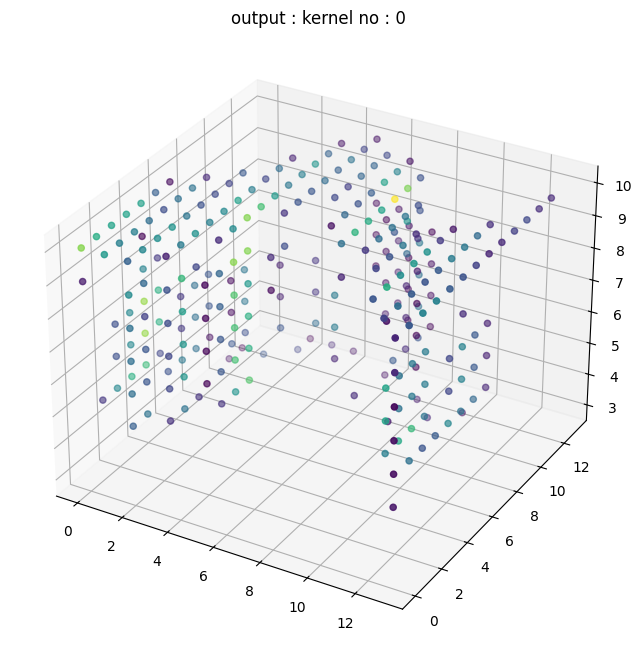

In [747]:
output=forward_pass_conv(X_train[0],kernel_size=(3,3,3),no_of_filters=1,activation='relu')
display_act_map(output,"output")

For the above, we are applying one **3 x 3 x 3** kernels, with stride and padding remaining the same.  
Thus, the expected output dimension is:  

$$(16 - 3 + 1) / 1 \times (16 - 3 + 1) / 1 \times (16 - 3 + 1) / 1 \times 1$$
Which equals
$$(14,14,14,1)$$

And we obtain the expected shape as shown below.


In [748]:
print(output.shape)

(14, 14, 14, 1)


## Step 3 : 3D Pooling function

In [749]:
# A function for pooling
def pooling(X, type='MAX', stride=1, pool_size=()):

    # Ensuring that the pool is made properly
    if pool_size==():
        pool_size=(stride,stride,stride)

    # Extracting the size of the input
    D,H,W,in_channels=X.shape

    # Determining the size of the output
    output_D=(D-pool_size[0])//stride + 1
    output_H=(H-pool_size[1])//stride + 1
    output_W=(W-pool_size[2])//stride + 1

    # Initializing the output
    output = np.zeros((output_D,output_H,output_W,in_channels))

    # Apply the max or average pool as per the input type
    for n in range(in_channels):
        for i in range(output_D):
            for j in range(output_H):
                for k in range(output_W):
                    pool = X[i*stride:i*stride+pool_size[0], j*stride:j*stride+pool_size[1], k*stride:k*stride+pool_size[2],n]
                    if(type=='MAX'):
                        output[i,j,k,n]=np.max(pool)
                    elif(type=='AVG'):
                        output[i,j,k,n]=np.mean(pool)
                
    
    return output

In [750]:
pool_output_max = pooling(output,'MAX',2,(2,2,2))
print(pool_output_max.shape)

(7, 7, 7, 1)


In [751]:
pool_output_avg = pooling(output,'AVG',2,(2,2,2))
print(pool_output_avg.shape)

(7, 7, 7, 1)


Since the pool size is (2,2,2) and the stride is also 2, the number of filters remain the same whereas the other dimensions half, the same is being observed above

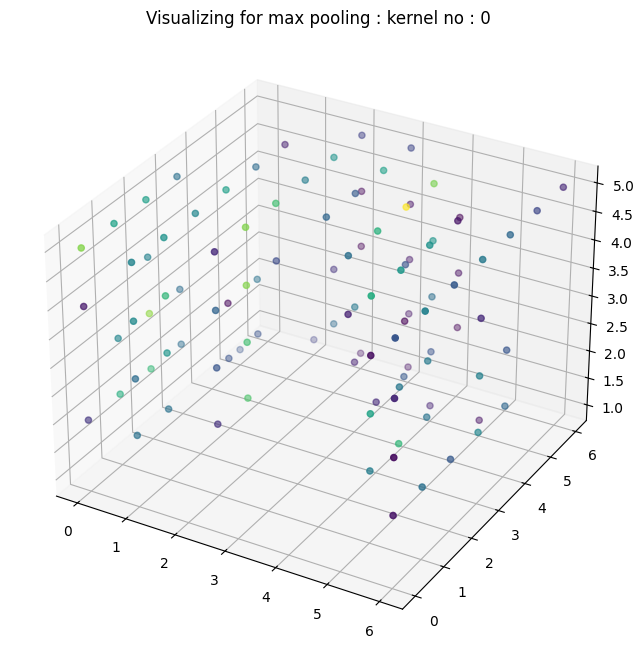

In [752]:
display_act_map(pool_output_max, "Visualizing for max pooling")

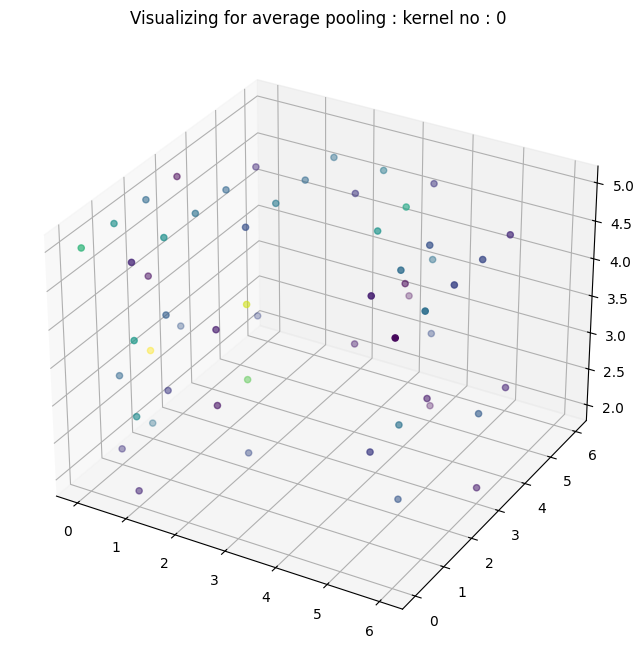

In [753]:
display_act_map(pool_output_avg, "Visualizing for average pooling")

Comparing the above two, we can see that compared to convolution, pooling is loosing more features. This seems to be happening because in pooling, we actually take either average or max of the pool, i.e. take just one value of the entire pool, whereas in convolution, depending on the stride, we actaully overlapping kernels, which lead to considering more points in our above example

One more observation is that MAX pooling is retaining more features than average pooling, the reason may be that max pooling takes the most significant or intense areas of the locations, that may edges, whereas average may be taking into account more smooth parts, which may suppress important parts .

## Step 4: 3D Convolution layer function

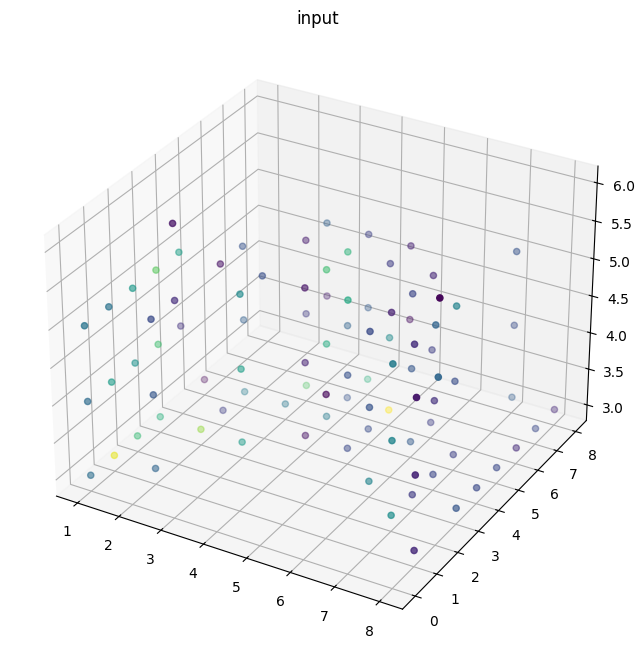

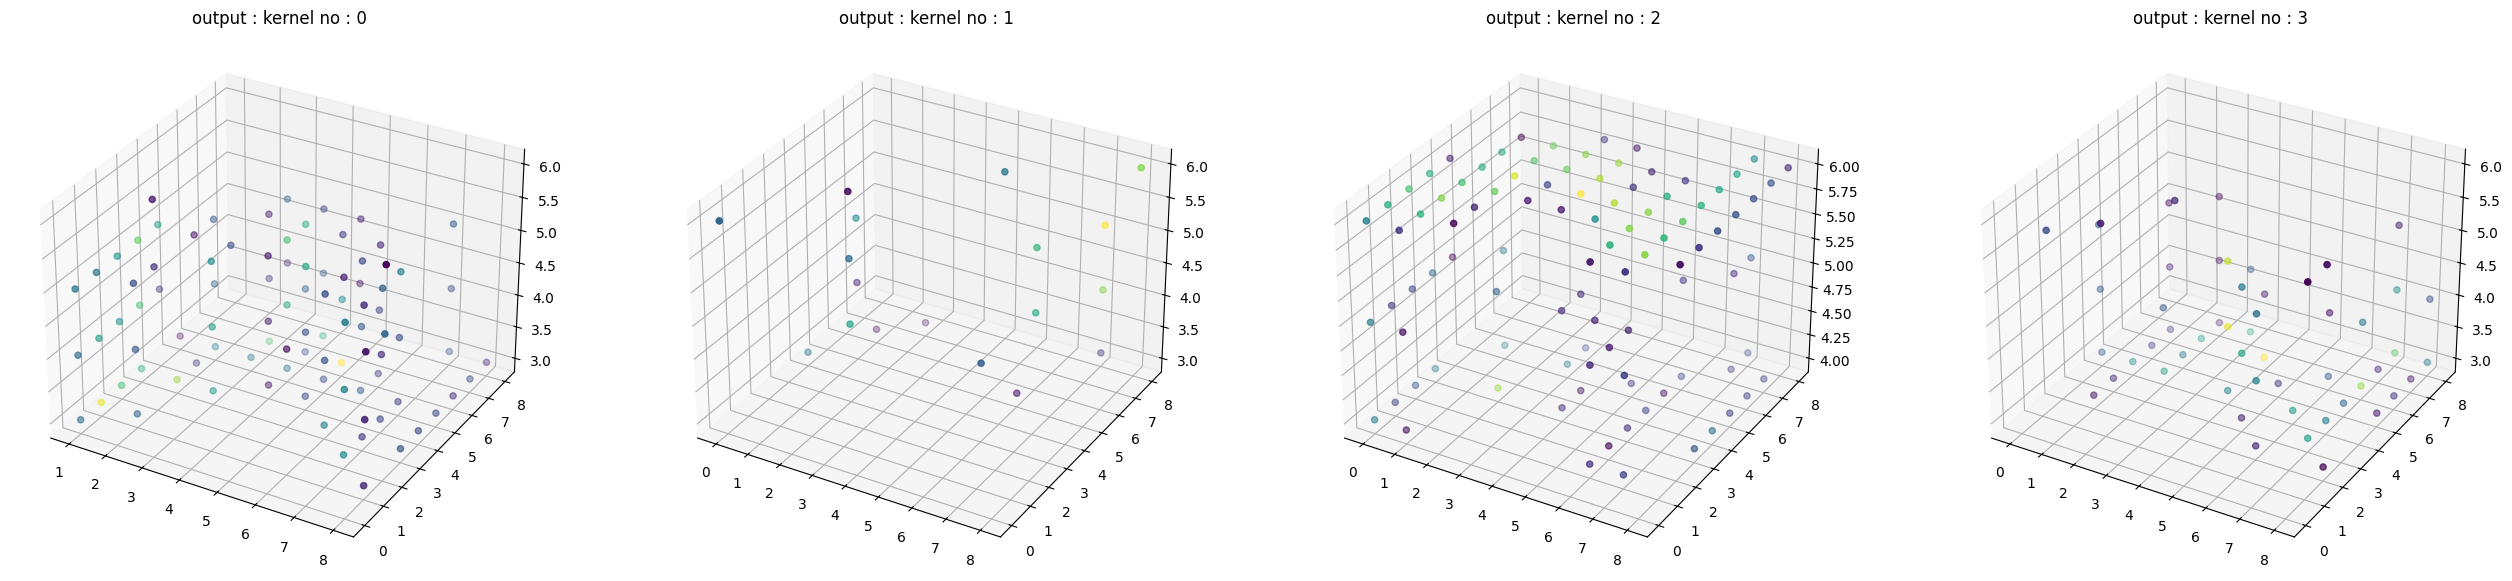

In [754]:
output=forward_pass_conv(X_train[0],kernel_size=(3,3,3),no_of_filters=4,stride=2,padding=2,activation='relu')
display_cloud(output,"input")
display_act_map(output,'output')

In [755]:
print(output.shape)

(9, 9, 9, 4)


As per the formula, output size is 
$$ (input\_dimension - kernel\_dimension + 2*padding) / stride + 1 $$
 $$(16 - 3 + 2*2)/2 + 1 = 9$$
Note we take the floor of the division
<br>
Finally the fourth dimension is number of filters = 4

## Step 5 : 3D Pooling layer function:

In [756]:
# Adding the special case of 'GAP'
def local_and_global_pooling(X, type='MAX', stride=1, pool_size=()):
    if(type=='GAP'):
        D,H,W,in_channels=X.shape
        output = np.zeros((1,1,1,in_channels))
        for n in range(in_channels):
            # We know that pooling happens channel wise
            pool = X[:,:,:,n]
            output[0,0,0,n]=np.mean(pool)
        
        return output
    else:
        return pooling(X,type,stride,pool_size)

In [757]:
pool_output_gap = local_and_global_pooling(output,'GAP')
print(pool_output_gap.shape)

(1, 1, 1, 4)


Clearly the spatial dimension is reducing

We have already seen the effect on MAX and Average pooling before. 

Further we note that GAP loses most spatial details

## Step 6 : Multilayer Perceptron (MLP) function

In [758]:
# Function to find the softmax
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0, keepdims=True)

# MLP with n_hidden layers, details of each hidden layer must be provided
def MLP(gap_output, n_hidden_layer, hidden_layers_neurons, activation='relu'):

    # Flatten the input, make it 1d
    x = gap_output.flatten()
    
    # Initialize the weights with Xavier initialization and the biases with zeros
    for i in range(n_hidden_layer):
        if i == 0:
            w = np.random.randn(hidden_layers_neurons[i], x.shape[0]) * np.sqrt(1/x.shape[0])
            b = np.zeros((hidden_layers_neurons[i], 1))
        else:
            w = np.random.randn(hidden_layers_neurons[i], hidden_layers_neurons[i-1]) * np.sqrt(1/hidden_layers_neurons[i-1])
            b = np.zeros((hidden_layers_neurons[i], 1))
        
        # Compute the forward pass operations
        s = np.dot(w, x.reshape(-1, 1)) + b
        x = apply_activation(s, activation)
    
    # Initialize the last output layer
    w = np.random.randn(10, hidden_layers_neurons[-1]) * np.sqrt(1/hidden_layers_neurons[-1])
    b = np.zeros((10, 1))
    
    # Apply softmax to the output layer
    output = softmax(np.dot(w, x) + b)
    
    return output


## Step 7: Putting-it all together

In [759]:
# Apply convolution as asked

def CNN(X):
    # A 3D convolution layer with 16 filters of size 5 ×5 ×5 and ReLU activation.
    s1 = forward_pass_conv(X,kernel_size=(5,5,5),no_of_filters=16,activation='relu')

    # A Max Pooling 3D layer of size 2 ×2 ×2 with stride 2.
    s2 = local_and_global_pooling(s1,type='MAX',stride=2,pool_size=(2,2,2))

    # A 3D convolution layer with 32 filters of size 3 ×3 ×3 and ReLU activation.
    s3 = forward_pass_conv(s2,kernel_size=(3,3,3),no_of_filters=32,activation='relu')

    # A Max Pooling 3D layer of size 2 ×2 ×2 with stride 2.
    s4 = local_and_global_pooling(s3,type='MAX',stride=2,pool_size=(2,2,2))

    # A Global Average Pooling (GAP) layer.
    s5 = local_and_global_pooling(s4,type='GAP')

    # An MLP with one hidden layer, where the input size matches the output of the GAP layer and the output size is 10 (one for each digit class). The hidden layer should use ReLU activation, and the output layer should apply softmax activation
    s6 = MLP(s5,1,[s5.shape[0]],'relu')

    return s6

In [760]:
vector = CNN(X_train[0])
print(vector)

[[1.78082556e-12]
 [3.88179424e-16]
 [1.22915044e-33]
 [3.48568680e-32]
 [5.18088531e-16]
 [9.99999751e-01]
 [5.29145173e-32]
 [4.23810726e-12]
 [5.33646544e-14]
 [2.48905932e-07]]


In [ ]:
max_index = np.argmax(vector)
print(max_index)

5


In [625]:
print(y_train[0])

5


Clearly the prediction is correct

# Q2

## Step 1 : Generating the dataset

### First let us construct the stack based function to count the number of balanced parenthesis

In [626]:
# Function to count the balanced paranthesis given a sequence s
def count_balanced_paranthesis(s):
    
    # The symbols that are accepted as parenthesis are the following
    open_paranthesis = ['[', '(', '<', '{']
    # The corresponding map
    closed_paranthesis = {']':'[', ')':'(', '>':'<', '}':'{'}

    # Define a stack to count the number of balanced paranthesis as per the question requirements
    stack = []
    counter = 0

    # Go character by character and check for parenthesis symbols
    for char in s:
        if(char in open_paranthesis):
            stack.append(char)
        elif(char in closed_paranthesis):
            if(len(stack)>=1 and stack[-1]==closed_paranthesis[char]):
                counter+=1
                stack.pop()

    return counter

In [627]:
# I want 6500 samples because I will do train test split later, so we want to train on atleast 5000 features
num_snippets = 6500

# Length of wach sequence or snippet is between 10 and 100
snippet_length_range = (10,100)

file_path = "assignment.cpp"
with open(file_path, "r", encoding="utf-8") as file:
    # First we extract the file such that the it has no spaces and empty lines
    text = "".join(file.read().split()) 

snippets = []
labels = []

# Then we randomly pick the samples from the file and create a database for future use
for _ in range(num_snippets):
    snippet_length = random.randint(*snippet_length_range)
    start_index = random.randint(0, len(text) - snippet_length)
    snippet = text[start_index:start_index + snippet_length]
    snippets.append(snippet)
    labels.append(count_balanced_paranthesis(snippet))

# Save snippets and labels to the dataset to a csv file
with open('output.csv', "w", encoding="utf-8") as file:
    for snippet, label in zip(snippets, labels):
        file.write(f"{snippet},{label}\n")

## Step 2: Defining all the helper functions that may be needed later on for the rest of the question

In [628]:
# Here I define all the characters that may occur in the file, any additional characters may just be ignored
characters = "abcdefghijklmonpqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ(){}[]<>.,/?@"

In [629]:
# We need to give an index to every character
def letter_to_index(char):
    return characters.find(char) if char in characters else -1

In [630]:
# We need to make a tensor for each sequence
def sequence_to_tensor(sequence):
    # I am fixing the batch size as 1 to avoid any complexities
    tensor=torch.zeros(len(sequence),1,len(characters))
    
    # Doing one hot encoding
    for i, letter in enumerate(sequence):
        index = letter_to_index(letter)
        if(index != -1):
            tensor[i][0][letter_to_index(letter)]=1
    return tensor

In [631]:
# Defining the baseline model as asked in the question
def baseline_model(sequence):
    # This model returns 1 regardless of the sequence
    return 1

In [632]:
# We will be using MSE loss throughout this question

criterion = nn.MSELoss()

In [633]:
# Get the training and testing samples ready
X_train, X_test, y_train, y_test = train_test_split(snippets, labels, test_size=0.2)

## Step 3: Elmon network

In [706]:
class RNN(nn.Module):

    # Initialization function
    def __init__(self,input_size,hidden_size,output_size,learning_rate=0.01):
        super(RNN,self).__init__()

        self.hidden_size=hidden_size

        # Defining the layer and the non-linearity
        self.input_to_hidden=nn.Linear(input_size+hidden_size,hidden_size)
        self.hidden_to_output=nn.Linear(hidden_size,output_size)
        self.tanh=nn.Tanh()
        self.relu=nn.ReLU()
        
        # We want to work with MSE loss
        self.criterion = nn.MSELoss()

        # Define the optimizer to improve performace
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    # Forward pass function
    def forward(self,input_tensor,hidden_tensor):
        combined=torch.cat((hidden_tensor,input_tensor),1)

        # Formulas as per the class notes (L-12 page 20)
        h_t = self.tanh(self.input_to_hidden(combined))
        y_t = self.hidden_to_output(h_t)
        return y_t,h_t
    
    # Helper function to initialize the hidden layer
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    
    def train_step(self,sequence_tensor,label):
        # Initialize the hidden layer
        h_t=self.init_hidden()

        # Go character by character
        for i in range(sequence_tensor.size()[0]):
            output, h_t = self(sequence_tensor[i],h_t)
        
        # Compute the loss
        loss = self.criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Return the floating values instead of the tensor
        return output.item(),loss.item()
    
    def predict(self,sequence):
        with torch.no_grad():

            # First conver the sequence to tensor
            sequence_tensor=sequence_to_tensor(sequence)

            # Initialize the hidden layer
            h_t=self.init_hidden()

            # Go through character by character
            for i in range(sequence_tensor.size()[0]):
                output,h_t=self(sequence_tensor[i],h_t)

            # Return value instead of the tensor
            return output.item()

In [707]:
hidden_size = 64  # hyperparameter that we can define
rnn = RNN(len(characters),hidden_size,1)

In [708]:
# Train the rnn for all the training points

no_of_epochs = 10
rnn_training_errors = []

for _ in range(no_of_epochs):
    for i in range(len(X_train)):
        label = y_train[i]
        sequence = X_train[i]
        sequence_tensor = sequence_to_tensor(sequence)
        output,loss = rnn.train_step(sequence_tensor,label)

    # Check training error
    predictions_train = []
    for x in X_train:
        predictions_train.append(rnn.predict(x))

    # Since we want to use the critereon, ensure that we are using tensors
    predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    training_error = rnn.criterion(predictions_train_tensor, y_train_tensor)
    rnn_training_errors.append(training_error.item())

/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [709]:
print(rnn_training_errors)

[2.654073476791382, 2.9009082317352295, 2.895202159881592, 2.6711020469665527, 2.6620213985443115, 2.904458999633789, 2.9075934886932373, 2.9075028896331787, 2.9075026512145996, 2.9075026512145996]


In [710]:
predictions_test = []
for x in X_test:
    predictions_test.append(rnn.predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

rnn_testing_error = rnn.criterion(predictions_test_tensor, y_test_tensor)
print(f"Testing Error (MSE): {rnn_testing_error.item()}")

Testing Error (MSE): 2.93806529045105


## Step 4 : LSTM

In [639]:
class LSTM(nn.Module):
    
    # Initialization function
    def __init__(self,input_size,hidden_size,output_size,learning_rate=0.01):
        super(LSTM,self).__init__()

        self.hidden_size=hidden_size

        # Defining the weights matrices
        self.W_f=nn.Linear(input_size+hidden_size,hidden_size) # Forget gate
        self.W_i=nn.Linear(input_size+hidden_size,hidden_size) # input gate
        self.W_o=nn.Linear(input_size+hidden_size,hidden_size) # output
        self.W_c=nn.Linear(input_size+hidden_size,hidden_size) # cell state update 

        # Defining output layer as well as the non-linearities
        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()

        # We want to work with MSE loss
        self.criterion = nn.MSELoss()

        # Define the optimizer to improve performace
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)


    def forward(self,input_tensor,hidden_tensor,cell_tensor):

        # All the following formulas are from the slides (L-12 page 99 onwards)

        combined=torch.cat((hidden_tensor,input_tensor),1)

        # Forget gate (page 99)
        f_t=self.sigmoid(self.W_f(combined))

        #Input gate (page 100)
        i_t=self.sigmoid(self.W_i(combined))
        c_t_2 = self.tanh(self.W_c(combined))
        
        # Cell update (page 102)
        c_t=f_t*cell_tensor+i_t*c_t_2
        
        # Output (page 103)
        o_t=self.sigmoid(self.W_o(combined))
        h_t=o_t*self.tanh(c_t)

        output = self.output_layer(h_t)
        return output,h_t,c_t
    
    # Hidden layer along with the cell state
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size), torch.zeros(1,self.hidden_size)
    
    # Training the LSTM
    def train_step(self,sequence_tensor,label):

        # Initialize the hidden and the cell state
        h_t, c_t=self.init_hidden()

        # Go through character by character
        for i in range(sequence_tensor.size()[0]):
            output, h_t, c_t = self(sequence_tensor[i],h_t, c_t)
        
        # Get the loss
        loss = self.criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Return the value and not the tensor
        return output.item(),loss.item()
    
    # Function to predict
    def predict(self,sequence):
        with torch.no_grad():
            # First convert the sequence to the tensor
            sequence_tensor=sequence_to_tensor(sequence)

            # Initialize the hidden and the cell state
            h_t,c_t=self.init_hidden()

            # Go through character by character in the forward pass
            for i in range(sequence_tensor.size()[0]):
                output,h_t,c_t=self(sequence_tensor[i],h_t,c_t)

            return output.item()

In [640]:
lstm = LSTM(len(characters),hidden_size,1)

In [641]:
# Train the rnn for all the training points

no_of_epochs = 10
lstm_training_errors = []

for _ in range(no_of_epochs):
    for i in range(len(X_train)):
        label = y_train[i]
        sequence = X_train[i]
        sequence_tensor = sequence_to_tensor(sequence)
        output,loss = lstm.train_step(sequence_tensor,label)

    # Check training error
    predictions_train = []
    for x in X_train:
        predictions_train.append(lstm.predict(x))

    # Since we want to use the critereon, ensure that we are using tensors
    predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    training_error = lstm.criterion(predictions_train_tensor, y_train_tensor)
    lstm_training_errors.append(training_error.item())

In [642]:
print(lstm_training_errors)

[2.4875264167785645, 0.4805099666118622, 0.28446218371391296, 0.28874680399894714, 0.34169691801071167, 0.14718376100063324, 0.09147071838378906, 0.06457728147506714, 0.04748554527759552, 0.0665639340877533]


In [643]:
#Testing error
predictions_test = []
for x in X_test:
    predictions_test.append(lstm.predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

lstm_testing_error = lstm.criterion(predictions_test_tensor, y_test_tensor)
print(f"Testing Error (MSE): {lstm_testing_error.item()}")

Testing Error (MSE): 0.07909823954105377


## Step 5 : GRU

In [644]:
class GRU(nn.Module):
    # Initialization function
    def __init__(self,input_size,hidden_size,output_size,learning_rate=0.01):
        super(GRU,self).__init__()

        self.hidden_size=hidden_size

        # The weights matrices corresponding to update, reset and hidden state
        self.W_z=nn.Linear(input_size+hidden_size,hidden_size) # update gate
        self.W_r=nn.Linear(input_size+hidden_size,hidden_size) # reset gate
        self.W=nn.Linear(input_size+hidden_size,hidden_size) # hidden state

        # Defining the output layer and the non-linearities used
        self.output_layer=nn.Linear(hidden_size,output_size)
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()

        # We want to work with MSE loss
        self.criterion = nn.MSELoss()

        # Define the optimizer to improve performace
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    # The forward pass
    def forward(self,input_tensor,hidden_tensor):
        # All the formulas used below are from the slides (L-12 page 106)

        combined=torch.cat((hidden_tensor,input_tensor),1)

        z_t=self.sigmoid(self.W_z(combined))
        r_t=self.sigmoid(self.W_r(combined))
        h_t_2 = self.tanh(self.W(torch.cat((r_t*hidden_tensor,input_tensor),1)))
        h_t=(1-z_t)*hidden_tensor + z_t*h_t_2

        output = self.output_layer(h_t)
        return output,h_t
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    
    def train_step(self,sequence_tensor,label):
        # Initialize the hidden layer
        h_t=self.init_hidden()

        # Go through the sequence character by character
        for i in range(sequence_tensor.size()[0]):
            output, h_t = self(sequence_tensor[i],h_t)

        # Define the los
        loss = self.criterion(output.squeeze(), torch.tensor([label], dtype=torch.float))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return output.item(),loss.item()
    
    # Function to predict the number of balanced paranthesis
    def predict(self,sequence):
        with torch.no_grad():
            # First ensure to convert the sequence to the tensor
            sequence_tensor=sequence_to_tensor(sequence)

            # Initialize the hidden layer
            h_t=self.init_hidden()

            # Go through character by character
            for i in range(sequence_tensor.size()[0]):
                output,h_t=self(sequence_tensor[i],h_t)

            return output.item()

In [645]:
gru = GRU(len(characters),hidden_size,1)

In [646]:
# Train the rnn for all the training points

no_of_epochs = 10
gru_training_errors = []

for _ in range(no_of_epochs):
    for i in range(len(X_train)):
        label = y_train[i]
        sequence = X_train[i]
        sequence_tensor = sequence_to_tensor(sequence)
        output,loss = gru.train_step(sequence_tensor,label)

    # Check training error
    predictions_train = []
    for x in X_train:
        predictions_train.append(gru.predict(x))

    # Since we want to use the critereon, ensure that we are using tensors
    predictions_train_tensor = torch.tensor(predictions_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    training_error = gru.criterion(predictions_train_tensor, y_train_tensor)
    gru_training_errors.append(training_error.item())

In [647]:
print(gru_training_errors)

[0.270119309425354, 0.21745027601718903, 0.11586616188287735, 0.12010589241981506, 0.12118881195783615, 0.11372385919094086, 0.1145932599902153, 0.11807119846343994, 0.16017772257328033, 0.055297382175922394]


In [648]:
predictions_test = []
for x in X_test:
    predictions_test.append(gru.predict(x))

predictions_test_tensor = torch.tensor(predictions_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

gru_testing_error = gru.criterion(predictions_test_tensor, y_test_tensor)
print(f"Testing Error (MSE): {gru_testing_error.item()}")

Testing Error (MSE): 0.06948764622211456


## Step 6 : Baseline

In [695]:
predictions_baseline_train = []
for x in X_train:
    predictions_baseline_train.append(baseline_model(x))

predictions_baseline_train_tensor = torch.tensor(predictions_baseline_train, dtype=torch.float32)
y_train_baseline = torch.tensor(y_train, dtype=torch.float32)

baseline_error = criterion(predictions_baseline_train_tensor, y_train_baseline)

baseline_train_errors = []
# We know that baseline error will remain constant, so directly display this
for _ in range(10):
    baseline_train_errors.append(baseline_error.item())

In [696]:
print(baseline_train_errors)

[2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117]


In [697]:
predictions_baseline_test = []
for x in X_test:
    predictions_baseline_test.append(baseline_model(x))

predictions_baseline_test_tensor = torch.tensor(predictions_baseline_test, dtype=torch.float32)
y_test_baseline = torch.tensor(y_test, dtype=torch.float32)

baseline_test_error = criterion(predictions_baseline_test_tensor, y_test_baseline)

In [698]:
print(baseline_test_error)

tensor(2.4785)


## Step 7: Comparisions

In [699]:
print(rnn_training_errors)

[2.486346483230591, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117, 2.4863462448120117]


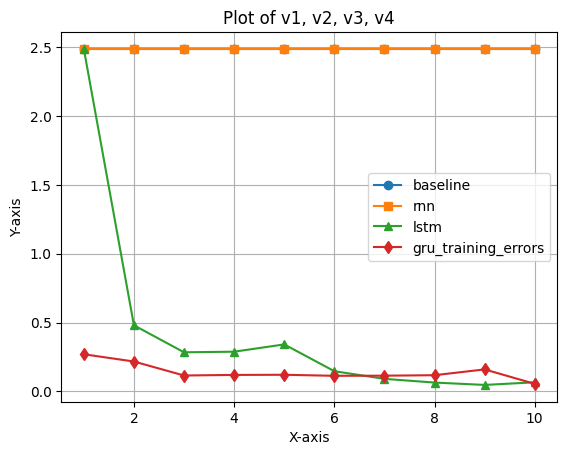

In [700]:
x = np.arange(1, 11)

# Plotting
plt.plot(x, baseline_train_errors, marker='o', label="baseline")
plt.plot(x, rnn_training_errors, marker='s', label="rnn")
plt.plot(x, lstm_training_errors, marker='^', label="lstm")
plt.plot(x, gru_training_errors, marker='d', label="gru_training_errors")

# Labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Plot of v1, v2, v3, v4")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

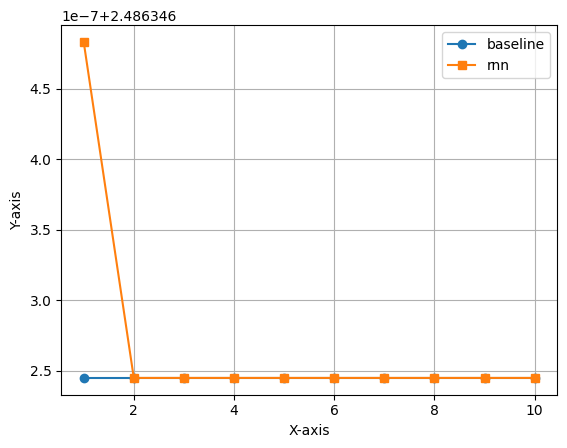

In [683]:
x = np.arange(1, 11)

# Plotting
plt.plot(x, baseline_train_errors, marker='o', label="baseline")
plt.plot(x, rnn_training_errors, marker='s', label="rnn")

# Labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [703]:
rnn_training_errors[6]

2.4863462448120117

In [704]:
baseline_train_errors[0]

2.4863462448120117